Run all the dependecis needed for this project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
!pip install langdetect deep-translator
from langdetect import detect
from deep_translator import GoogleTranslator
import time
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tensorflow.keras.callbacks import Callback
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

2025-04-13 07:31:08.830321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744529468.984364      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744529469.028283      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.8 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=6a095d090caf80ea4919eee1daaced2f52b047f09ef4f2c5b7b2100c6c4683ea
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


**Mounting google drive to access the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load all the Datasets, such as Train, Test & Validation

In [ ]:
train_dataset = pd.read_csv('/kaggle/input/testasdasdasd/train.csv')
test_dataset = pd.read_csv('/kaggle/input/testasdasdasd/test.csv')
validation_dataset = pd.read_csv('/kaggle/input/testasdasdasd/validation.csv')

**Step 1: Exploratory Data Analysis (EDA)**


Seeing the shape off given dataset

In [ ]:
train_dataset.shape

(23473, 8)

In [ ]:
test_dataset.shape

(6000, 3)

In [ ]:
validation_dataset.shape

(840, 4)

Seeing the info of dataset

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23473 entries, 0 to 23472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             23473 non-null  object
 1   feedback_text  23473 non-null  object
 2   toxic          23473 non-null  int64 
 3   abusive        23473 non-null  int64 
 4   vulgar         23473 non-null  int64 
 5   menace         23473 non-null  int64 
 6   offense        23473 non-null  int64 
 7   bigotry        23473 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB


In [ ]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       6000 non-null   int64 
 1   content  6000 non-null   object
 2   lang     6000 non-null   object
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [ ]:
validation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             840 non-null    int64 
 1   feedback_text  840 non-null    object
 2   lang           840 non-null    object
 3   toxic          840 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 26.4+ KB


Checking, is there any null valur or not

In [ ]:
train_dataset.isnull().sum()

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64

In [ ]:
test_dataset.isnull().sum()

id         0
content    0
lang       0
dtype: int64

In [ ]:
validation_dataset.isnull().sum()

id               0
feedback_text    0
lang             0
toxic            0
dtype: int64

**Due to GPU limitations and to ensure proper training and testing, I have sampled a subset of data from the training, validation, and test datasets. Below are a few example rows from each set.**

In [ ]:
train_file = train_dataset.head(10000)
train_file.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [ ]:
test_file = test_dataset.head(2000)
test_file.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [ ]:
validation_file = validation_dataset.head(800)
validation_file.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


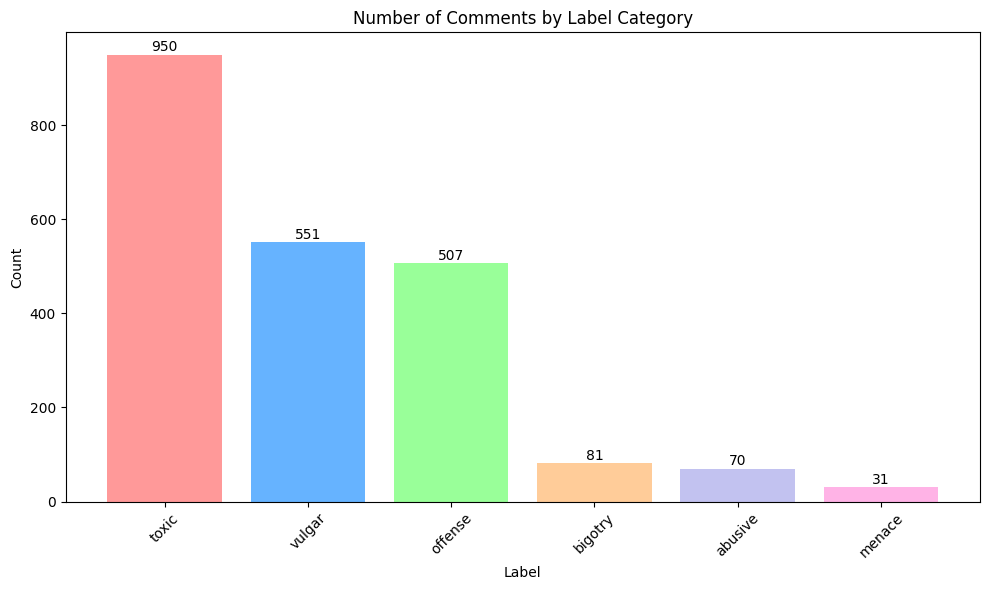

In [ ]:
label_columns = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
label_counts = train_file[label_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C2C2F0', '#FFB3E6']
bars = plt.bar(label_counts.index, label_counts.values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, int(height), ha='center', va='bottom')
plt.title("Number of Comments by Label Category")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dropping unnecessary columns for all dataset

In [ ]:
train_file.drop(columns=['id'], inplace=True)
test_file.drop(columns=['lang'], inplace=True)
validation_file.drop(columns=['id', 'lang'], inplace=True)

/tmp/ipykernel_31/3336751227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_file.drop(columns=['id'], inplace=True)
/tmp/ipykernel_31/3336751227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_file.drop(columns=['lang'], inplace=True)
/tmp/ipykernel_31/3336751227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_file.drop(columns=['id', 'lang'], inplace=True)


Seeing the Correlation Matrix of train dataset

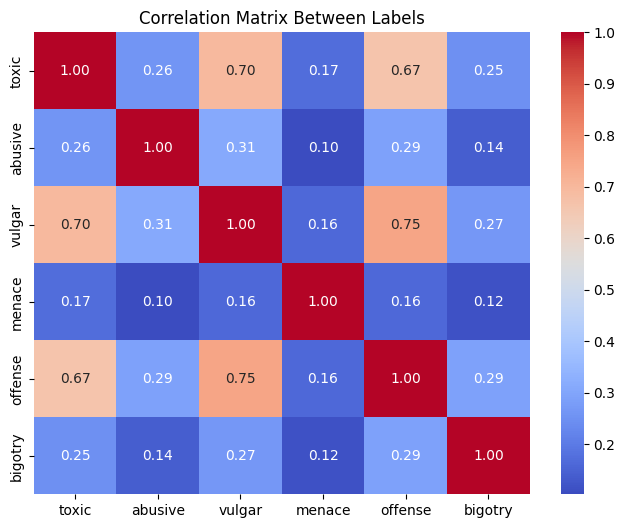

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
corr_matrix = train_file[label_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Labels")
plt.show()

Co-occurance of toxicity with other labels

In [ ]:
toxic_co_counts = {}
for col in label_cols:
    if col != 'toxic':
        toxic_co_counts[col] = ((train_dataset['toxic'] == 1) & (train_dataset[col] == 1)).sum()
co_occurs_df = pd.DataFrame.from_dict(toxic_co_counts, orient='index', columns=['Co-occurrence with Toxic'])
co_occurs_df = co_occurs_df.sort_values(by='Co-occurrence with Toxic', ascending=False)

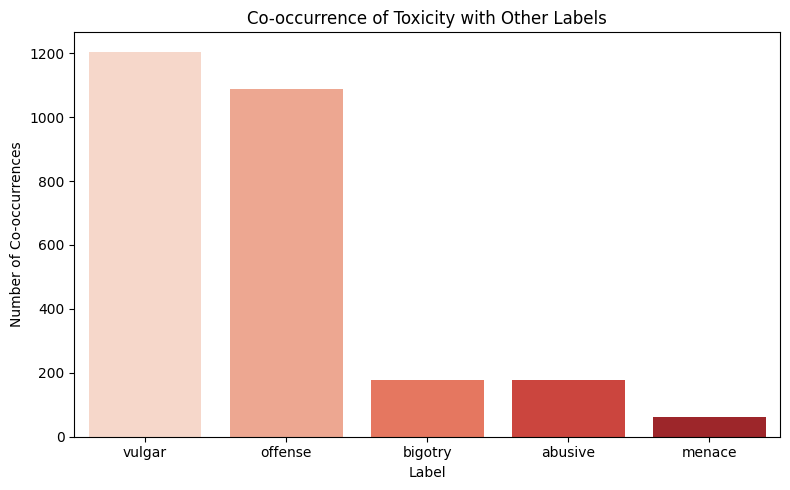

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=co_occurs_df.index, y='Co-occurrence with Toxic', data=co_occurs_df, palette='Reds')
plt.title('Co-occurrence of Toxicity with Other Labels')
plt.ylabel('Number of Co-occurrences')
plt.xlabel('Label')
plt.tight_layout()
plt.show()

**Step 2 :Text Preprocessing**


Building the language translation function

In [ ]:
def translate_if_not_english(text):
    try:
        lang = detect(str(text))
        if lang != 'en':
            time.sleep(1)
            return GoogleTranslator(source='auto', target='en').translate(text)
        else:
            return text
    except:
        return text

Translating the text

In [ ]:
train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(translate_if_not_english)
test_file.loc[:, 'content'] = test_file['content'].apply(translate_if_not_english)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(translate_if_not_english)

Preprocessing full function

In [ ]:
def preprocess(text):
    text = text.lower().strip()
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'https?://(?:www\.)?\S+|www\.\S+', '', text)
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('[math]', '')
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)
    contractions = {
        "can't": "can not", "won't": "will not", "i'm": "i am", "it's": "it is", "you're": "you are",
        "they're": "they are", "we're": "we are", "isn't": "is not", "aren't": "are not",
        "wasn't": "was not", "weren't": "were not", "doesn't": "does not", "don't": "do not",
        "didn't": "did not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "wouldn't": "would not", "shouldn't": "should not", "couldn't": "could not",
        "mightn't": "might not", "mustn't": "must not",
        "let's": "let us", "that's": "that is", "who's": "who is", "what's": "what is",
        "here's": "here is", "there's": "there is", "how's": "how is",
        "i've": "i have", "we've": "we have", "you've": "you have", "they've": "they have",
        "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will", "we'll": "we will",
        "they'll": "they will", "i'd": "i would", "you'd": "you would", "he'd": "he would",
        "she'd": "she would", "we'd": "we would", "they'd": "they would"
    }

    words = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        words.append(word)
    text = ' '.join(words)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

Applying preprocess

In [ ]:
train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(preprocess)
test_file.loc[:, 'content'] = test_file['content'].apply(preprocess)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(preprocess)

Lemmatization : Word convert into root word itself

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train_file.loc[:, 'feedback_text'] = train_file['feedback_text'].apply(lemmatize_text)
test_file.loc[:, 'content'] = test_file['content'].apply(lemmatize_text)
validation_file.loc[:, 'feedback_text'] = validation_file['feedback_text'].apply(lemmatize_text)

In [ ]:
x_train_text = train_file['feedback_text']
x_valid_text = validation_file['feedback_text']
y_train_toxic = train_file['toxic']
y_valid_toxic = validation_file['toxic']

TF-IDF Vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_text)
x_valid_tfidf = tfidf_vectorizer.transform(x_valid_text)

Model : LogisticRegression

In [ ]:
lr= LogisticRegression()
lr.fit(x_train_tfidf, y_train_toxic)
y_pred_lr = lr.predict(x_valid_tfidf)
y_prob_lr = lr.predict_proba(x_valid_tfidf)[:, 1]

Performance evaluation of LogisticRegression

In [ ]:
print("Logistic Regression Performance:\n")
print(classification_report(y_valid_toxic, y_pred_lr))

Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       676
           1       0.90      0.07      0.13       124

    accuracy                           0.85       800
   macro avg       0.88      0.54      0.53       800
weighted avg       0.86      0.85      0.80       800



Confusion Matrix - Logistic Regression

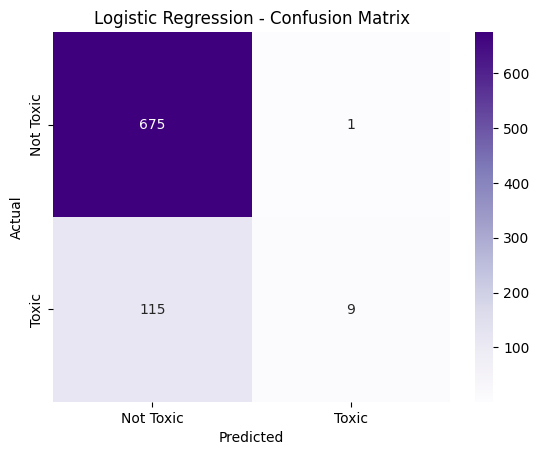

In [ ]:
confusion_matrix_lr = confusion_matrix(y_valid_toxic, y_pred_lr)
sns.heatmap(confusion_matrix_lr, annot=True, fmt="d", cmap="Purples", xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve - Logistic Regression

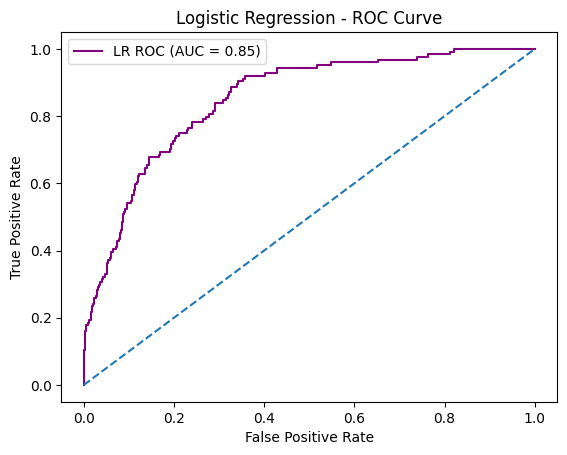

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_valid_toxic, y_prob_lr)
auc_lr = roc_auc_score(y_valid_toxic, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f"LR ROC (AUC = {auc_lr:.2f})", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.legend()
plt.show()

Random Forest Clasifier


In [ ]:
rf= RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_tfidf, y_train_toxic)
y_pred_rf = rf.predict(x_valid_tfidf)
y_prob_rf = rf.predict_proba(x_valid_tfidf)[:, 1]

Performance evaluation of Random Forest Clasifier

In [ ]:
print("Random Forest Performance:\n")
print(classification_report(y_valid_toxic, y_pred_rf))

Random Forest Performance:

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       676
           1       0.93      0.10      0.19       124

    accuracy                           0.86       800
   macro avg       0.89      0.55      0.56       800
weighted avg       0.87      0.86      0.81       800



Confusion Matrix - Random Forest


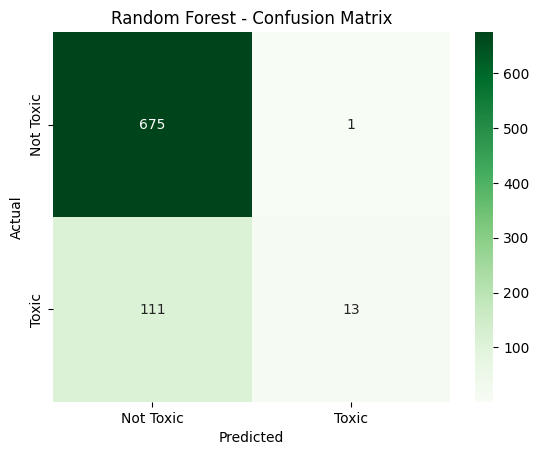

In [ ]:
confusion_matrix_rf = confusion_matrix(y_valid_toxic, y_pred_rf)
sns.heatmap(confusion_matrix_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["Not Toxic", "Toxic"], yticklabels=["Not Toxic", "Toxic"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve - Random Forest

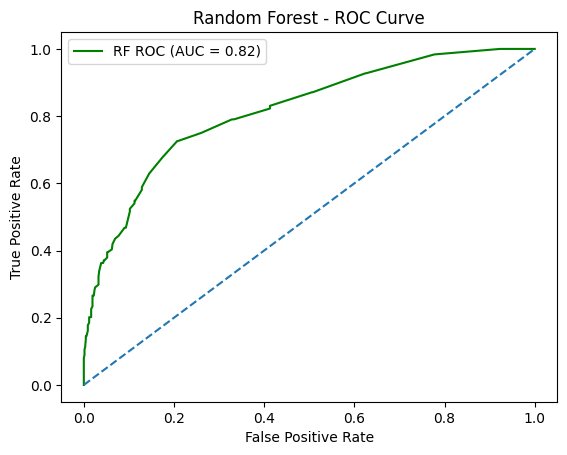

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_valid_toxic, y_prob_rf)
auc_rf = roc_auc_score(y_valid_toxic, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RF ROC (AUC = {auc_rf:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.show()

Prediction

In [ ]:
output_df = pd.DataFrame({
    "feedback_text": x_valid_text,
    "actual_toxic": y_valid_toxic.values,
    "logistic_pred": y_pred_lr,
    "random_forest_pred": y_pred_rf
})

In [ ]:
print("Prediction Output Sample:")
output_df.head()

Prediction Output Sample:


,feedback_text,actual_toxic,logistic_pred,random_forest_pred
0,well okay we improve the balkan substance and ...,0,0,0
1,by god and john lennon song will now be more i...,1,0,0
2,hi first of all i congratulate you in the mean...,0,0,0
3,read all the discussion maybe delete and get b...,1,0,0
4,a la tokitas no vale que la jonaticas insulten...,1,0,0


Matric Comparison

In [ ]:
metrics_dict = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_valid_toxic, y_pred_lr),
        accuracy_score(y_valid_toxic, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_valid_toxic, y_pred_lr),
        precision_score(y_valid_toxic, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_valid_toxic, y_pred_lr),
        recall_score(y_valid_toxic, y_pred_rf)
    ],
    "F1 Score": [
        f1_score(y_valid_toxic, y_pred_lr),
        f1_score(y_valid_toxic, y_pred_rf)
    ]
}

In [ ]:
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index("Model", inplace=True)

Metrics Comparison

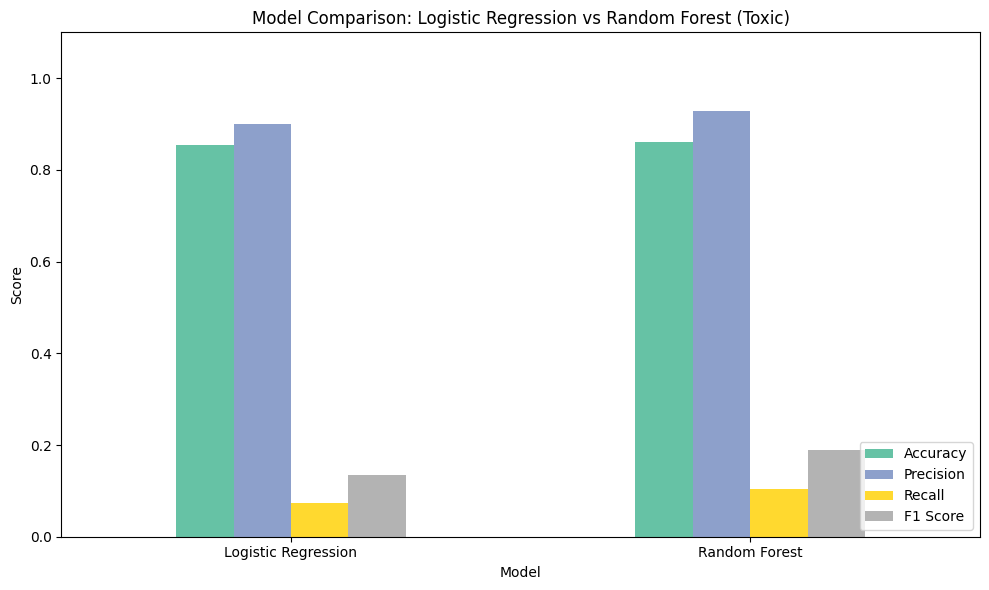

In [ ]:
metrics_df.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title("Model Comparison: Logistic Regression vs Random Forest (Toxic)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Summary Table

In [ ]:
print("Summary Table:")
display(metrics_df.round(3))

Summary Table:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.855,0.900,0.073,0.134
Random Forest,0.860,0.929,0.105,0.188
